In [38]:
from qiskit import QuantumCircuit

In [39]:
# User inputs
want_colors = 1 # from input 1=color, 0=b/w
seconds = 180 # length of generated gif
fps = 12
x = 100 # dimension of generated image ( # of tiles in x)
y = 100 # dimension of generated image ( # of tiles in y)

frameAmount = seconds * fps

In [40]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
print(provider.backends())
backend = provider.get_backend('ibm_nairobi')

[<IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_lagos')>]


In [41]:
# Create a Quantum Circuit acting on a quantum register of seven qubits
qubits = 7
circ = QuantumCircuit(qubits)

#always is variable 0-1
circ.h(1) #shape
circ.h(5) #rot1
circ.h(6) #rot2

# set q0 to 1 if wants colors
if want_colors:
    circ.x(0)

# Set colors to 0-1 if q0 is 1 (want_colors)
circ.ch(0, 2) #colors1 0-1 if q0 is 1
circ.ch(0, 3) #colors2 0-1 if q0 is 1

# Set b/w-w/b to 0-1 if !want_colors
circ.x(0) #invert q0
circ.ch(0, 4) #b/w 0-1 if q0 is 1 now

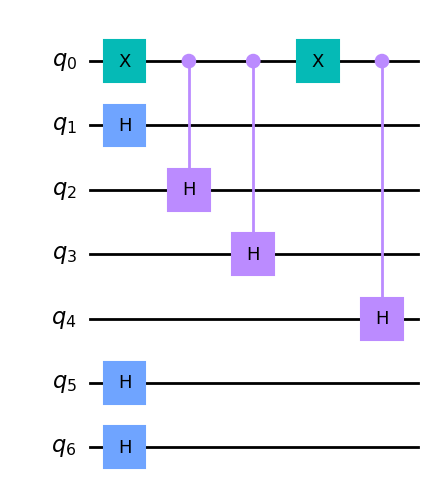

In [42]:
circ.draw('mpl')

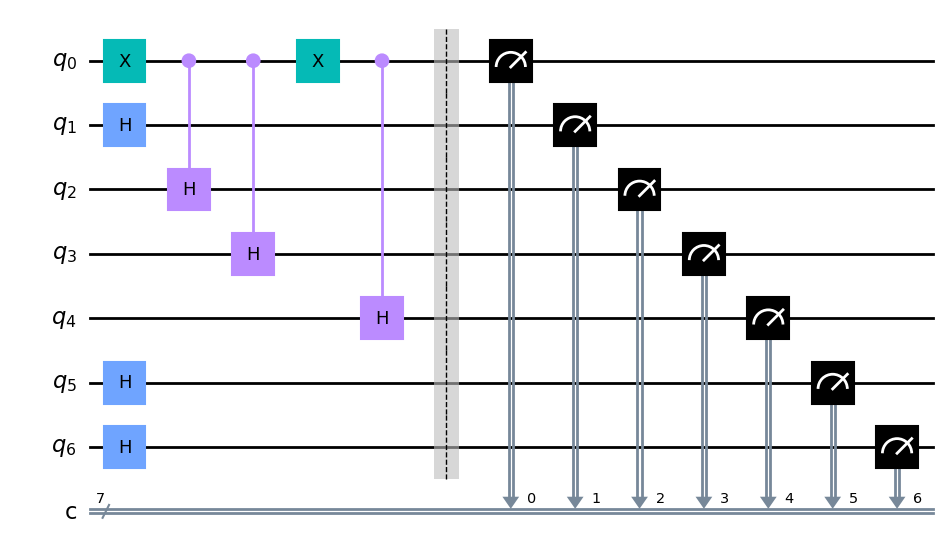

In [45]:
# Create a Quantum Circuit
meas = QuantumCircuit(qubits, qubits)
meas.barrier(range(qubits))
# map the quantum measurement to the classical bits
meas.measure(range(qubits), range(qubits))

# The Qiskit circuit object supports composition.
# Here the meas has to be first and front=True (putting it before) 
# as compose must put a smaller circuit into a larger one.
qc = meas.compose(circ, range(qubits), front=True)

#drawing the circuit
qc.draw('mpl')

In [ ]:
# Adding the transpiler to reduce the circuit to QASM instructions
# supported by the backend
from qiskit import compiler

qc_compiled = compiler.transpile(qc, backend, optimization_level=2)

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
job = backend.run(qc_compiled, shots=x*y, memory=True)
jobGlitch = backend.run(qc_compiled, shots=1000, memory=True)

# Grab the results from the job.
result = job.result()
resultGlitch = jobGlitch.result()

memory = result.get_memory(0)
memoryGlitch = resultGlitch.get_memory(0)
print(memory)
print(len(memory))


In [ ]:
counts = result.get_counts(qc_compiled)
print(counts)

In [ ]:
from PIL import Image, ImageDraw, ImageFilter

tileFileNames = ['0000000','0000001','0000010','0000011','0001000','0001001','0001010','0001011','0010000','0010001','0010010','0010011','0011000','0011001','0011010','0011011','0100000','0100001','0100010','0100011','0101000','0101001','0101010','0101011','0110000','0110001','0110010','0110011','0111000','0111001','0111010','0111011','1000000','1000001','1000010','1000011','1000100','1000101','1000110','1000111','1100000','1100001','1100010','1100011','1100100','1100101','1100110','1100111']
tiles = {}
for tile in tileFileNames:
    tiles[tile] = Image.open('tiles/'+tile+'.png')

tile_size = 128
image = Image.new(mode="RGB", size=(x*tile_size, y*tile_size))

for idx, i in enumerate(memory):
    tile_x = idx % x
    tile_y = idx // x
    im = tiles[i[::-1]]
    image.paste(im, (tile_x*tile_size, tile_y*tile_size))
image.save('output.png', quality=100)
display(image)

In [ ]:
# Create a Quantum Circuit
glitchingCircuit = QuantumCircuit(4)

glitchingCircuit.h(0)
glitchingCircuit.h(1)
glitchingCircuit.h(2)
glitchingCircuit.h(3)

glitchingCircuit.u(2, 0, 3, 1)
glitchingCircuit.u(2, 0, 3, 2)
glitchingCircuit.u(2, 0, 3, 3)
glitchingCircuit.u(2, 0, 3, 0)
# glitchingCircuit.measure(2,[0])
glitchingCircuit.x(3)

meas = QuantumCircuit(4, 4)
meas.barrier(range(4))
# map the quantum measurement to the classical bits
meas.measure(range(4), range(4))

# The Qiskit circuit object supports composition.
# Here the meas has to be first and front=True (putting it before) 
# as compose must put a smaller circuit into a larger one.
qc = meas.compose(glitchingCircuit, range(4), front=True)

#drawing the circuit
qc.draw('mpl')

In [ ]:
#prepare randomnes data for glitching

qc_compiled = compiler.transpile(qc, backend)

glitchOpportunities = frameAmount
job = backend.run(qc_compiled, shots=glitchOpportunities, memory=True)

# Grab the results from the job.
result = job.result()

glitchMemory = result.get_memory(0)

In [ ]:
counts = result.get_counts(qc_compiled)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [ ]:
from copy import deepcopy

timePerFrame = 1 / fps

frames = [image];

for frame in range(frameAmount):
    newImage = deepcopy(frames[-1])
    for idx, i in enumerate(memory):
        if glitchMemory[(idx * frame) % frameAmount] == '0010':
            tile_x = idx % x
            tile_y = idx // x
            randomFile = memoryGlitch.pop()
            im = tiles[randomFile[::-1]]
            newImage.paste(im, (tile_x*128, tile_y*128))
    frames.append(deepcopy(newImage))
    
frames[0].save('output.gif',
               save_all=True, append_images=frames[1:], optimize=False, duration=timePerFrame, loop=0)